# LSTM Sine Wave

### Overview
Predict a simple sine wave using LSTM

Adopted with thanks from [here](https://www.datatechnotes.com/2018/12/rnn-example-with-keras-simplernn-in.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

print ('tensorflow version:', tf.__version__)
print (tf.config.experimental.list_physical_devices())

# number formats
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

tensorflow version: 2.3.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## TF-GPU Debug
The following block tests if TF is running on GPU.

In [2]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5



## Generate some data

In [3]:
# Generate 1000 samples
samples = 1000    
training_samples = 800    

t=np.arange(0,samples)

## Generating a sine wave, with some noise 
x=np.sin(0.02*t)+2*np.random.rand(samples)

## print data
df_orig = pd.DataFrame(x)
df_orig


,0
0,1.4747
1,1.9762
2,0.8371
3,0.8558
4,1.3168
...,...
995,2.4307
996,2.7399
997,2.7866
998,2.6515


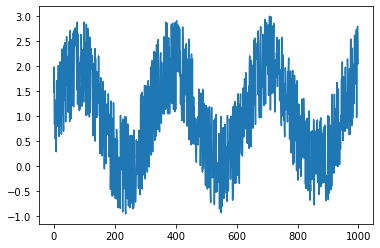

In [4]:
## plot data
plt.plot(df_orig)
plt.show() 

## Train / Test split

In [5]:
## Create train / test values

values=df_orig.values
train,test = values[0:training_samples,:], values[training_samples:samples,:]

print ("values:" , values[1:20])
print ('train size', len(train))
print ('test size', len(test))

values: [[ 1.9762]
 [ 0.8371]
 [ 0.8558]
 [ 1.3168]
 [ 0.5385]
 [ 1.2150]
 [ 1.1637]
 [ 0.2841]
 [ 1.6817]
 [ 1.7065]
 [ 0.7902]
 [ 0.9359]
 [ 0.9155]
 [ 1.2909]
 [ 2.0033]
 [ 0.7380]
 [ 0.5911]
 [ 0.7787]
 [ 1.1692]]
train size 800
test size 200


In [6]:
## padding the data
step = 4
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

print ("train size", len(train))
print ("test size", len(test))

train size 804
test size 204


In [7]:
## see some data
## compare with original data
train[:30]

array([ 1.4747,  1.9762,  0.8371,  0.8558,  1.3168,  0.5385,  1.2150,
        1.1637,  0.2841,  1.6817,  1.7065,  0.7902,  0.9359,  0.9155,
        1.2909,  2.0033,  0.7380,  0.5911,  0.7787,  1.1692,  2.0796,
        0.7998,  1.7043,  1.6833,  0.9985,  0.6351,  1.2860,  2.3369,
        2.1727,  1.0236])

In [8]:
## vectorize the data

def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

x_train,y_train =convertToMatrix(train,step)
x_test,y_test =convertToMatrix(test,step)

print ("x_train.shape", x_train.shape)
print ("y_train.shape", y_train.shape)
print ("x_test.shape", x_test.shape)
print ("y_test.shape", y_test.shape)

x_train.shape (800, 4)
y_train.shape (800,)
x_test.shape (200, 4)
y_test.shape (200,)


In [9]:
## See data
df = pd.DataFrame(x_train, y_train)
df

,0,1,2,3
1.3168,1.4747,1.9762,0.8371,0.8558
0.5385,1.9762,0.8371,0.8558,1.3168
1.2150,0.8371,0.8558,1.3168,0.5385
1.1637,0.8558,1.3168,0.5385,1.2150
0.2841,1.3168,0.5385,1.2150,1.1637
...,...,...,...,...
1.0169,0.9831,0.4607,-0.0929,1.7005
1.0169,0.4607,-0.0929,1.7005,1.0169
1.0169,-0.0929,1.7005,1.0169,1.0169
1.0169,1.7005,1.0169,1.0169,1.0169


In [10]:
## Finally, we'll reshape trainX and testX to fit with the Keras model. 
## RNN model requires three-dimensional input data.

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print ("x_train.shape", x_train.shape)
print ("y_train.shape", y_train.shape)
print ("x_test.shape", x_test.shape)
print ("y_test.shape", y_test.shape)

x_train.shape (800, 1, 4)
y_train.shape (800,)
x_test.shape (200, 1, 4)
y_test.shape (200,)


## Build LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1344      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


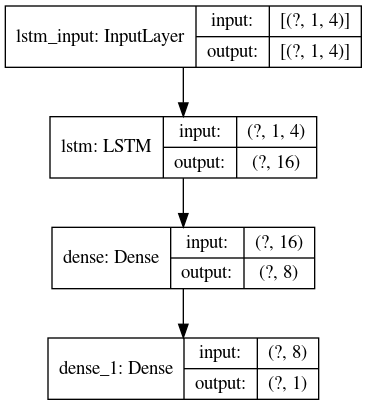

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=16, input_shape=(1,step)))
# model.add(keras.layers.GRU(units=16, input_shape=(1,step)))
model.add(keras.layers.Dense(8, activation="relu")) 
model.add(keras.layers.Dense(1))
model.compile(optimizer='rmsprop', loss = 'mse', metrics=['mse'])
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Setup Tensorboard

In [12]:
## This is fairly boiler plate code

import datetime
import os
import shutil

app_name = 'rnn-sine'

# timestamp  = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

tb_top_level_dir= '/tmp/tensorboard-logs'

tb_app_dir = os.path.join (tb_top_level_dir, app_name)

tb_logs_dir = os.path.join (tb_app_dir, datetime.datetime.now().strftime("%H-%M-%S"))


print ("Saving TB logs to : " , tb_logs_dir)

#clear out old logs
shutil.rmtree ( tb_app_dir, ignore_errors=True )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_logs_dir, write_graph=True, 
                                                      write_images=True, histogram_freq=1)

## This will embed Tensorboard right here in jupyter!
%load_ext tensorboard
%tensorboard --logdir $tb_logs_dir

Saving TB logs to :  /tmp/tensorboard-logs/rnn-sine/20-52-14


## Train

In [13]:
%%time

print ("training starting ...")

# Fitting the network to the Training set
history = model.fit(x_train, y_train, epochs=100, batch_size=16,
                   callbacks = [tensorboard_callback])

print ("training done.")

training starting ...
Epoch 1/100
 1/50 [..............................] - ETA: 0s - loss: 1.9456 - mse: 1.9456WARNING:tensorflow:From /home/sujee/anaconda3/envs/tf-2.3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
50/50 [==============================] - 0s 2ms/step - loss: 1.7432 - mse: 1.7432
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 1.0884 - mse: 1.0884
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.6002 - mse: 0.6002
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.4421 - mse: 0.4421
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.4297 - mse: 0.4297
Epoch 6/100
50/50 [==============================] - 0s 3ms/step - loss: 0.4258 - mse: 0.4258
Epoch 7/100
50/50 [=================

## Training History

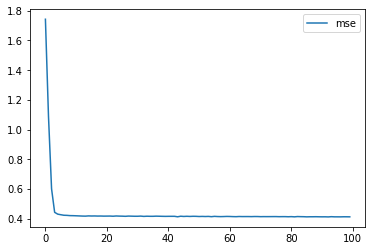

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='mse')
plt.legend()
plt.show()

## Prediction

In [15]:
predict_train = model.predict(x_train)
predict_test= model.predict(x_test)

predicted=np.concatenate((predict_train,predict_test),axis=0)

print (predicted[:10])


[[ 1.3235]
 [ 1.3598]
 [ 0.8834]
 [ 1.0837]
 [ 1.1732]
 [ 0.7319]
 [ 1.2635]
 [ 1.3464]
 [ 1.0638]
 [ 1.3510]]


## Evaluate

In [16]:
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

print ("train_score", train_score)
print ("test_score", test_score)

train_score [0.40894028544425964, 0.40894028544425964]
test_score [0.34827563166618347, 0.34827563166618347]


In [17]:
metric_names = model.metrics_names
print ("model metrics : " , metric_names)

train_metrics = model.evaluate(x_train, y_train, verbose=0)
for idx, metric in enumerate(metric_names):
    print ("Train Metric : {} = {:,.2f}".format (metric_names[idx], train_metrics[idx]))
    
test_metrics = model.evaluate(x_test, y_test, verbose=0)
for idx, metric in enumerate(metric_names):
    print ("Test Metric : {} = {:,.2f}".format (metric_names[idx], test_metrics[idx]))

model metrics :  ['loss', 'mse']
Train Metric : loss = 0.41
Train Metric : mse = 0.41
Test Metric : loss = 0.35
Test Metric : mse = 0.35


## Plot

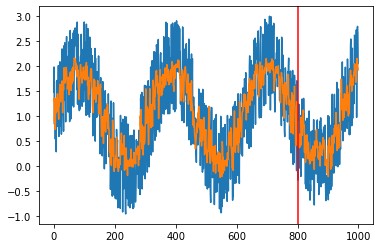

In [18]:
index = df_orig.index.values
plt.plot(df_orig)
plt.plot(predicted)
plt.axvline(df_orig.index[training_samples], c="r")
plt.show()